In [1]:
%matplotlib inline
import re
import csv
import nltk
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# The function text_to_wordlist is adapted from:
# kaggle.com/currie32/quora-question-pairs/the-importance-of-cleaning-text

def text_to_wordlist(
                     question, 
                     remove_stopwords   = False, 
                     stem_words         = False,
                     remove_punctuation = False
                    ):

    question = re.sub( r"[^A-Za-z0-9^,!.\/'+-=]", " "          , question)
    question = re.sub( r"what's"                , "what is "   , question)
    question = re.sub( r"\'s"                   , " "          , question)
    question = re.sub( r"\'ve"                  , " have "     , question)
    question = re.sub( r"can't"                 , "cannot "    , question)
    question = re.sub( r"n't"                   , " not "      , question)
    question = re.sub( r"i'm"                   , "i am "      , question)
    question = re.sub( r"\'re"                  , " are "      , question)
    question = re.sub( r"\'d"                   , " would "    , question)
    question = re.sub( r"\'ll"                  , " will "     , question)
    question = re.sub( r","                     , " "          , question)
    question = re.sub( r"\."                    , " "          , question)
    question = re.sub( r"!"                     , " ! "        , question)
    question = re.sub( r"\/"                    , " "          , question)
    question = re.sub( r"\^"                    , " ^ "        , question)
    question = re.sub( r"\+"                    , " + "        , question)
    question = re.sub( r"\-"                    , " - "        , question)
    question = re.sub( r"\="                    , " = "        , question)
    question = re.sub( r"'"                     , " "          , question)
    question = re.sub( r"(\d+)(k)"              , r"\g<1>000"  , question)
    question = re.sub( r":"                     , " : "        , question)
    question = re.sub( r" e g "                 , " eg "       , question)
    question = re.sub( r" b g "                 , " bg "       , question)
    question = re.sub( r" u s "                 , " american " , question)
    question = re.sub( r"\0s"                   , "0"          , question)
    question = re.sub( r" 9 11 "                , "911"        , question)
    question = re.sub( r"e - mail"              , "email"      , question)
    question = re.sub( r"j k"                   , "jk"         , question)
    question = re.sub( r"\s{2,}"                , " "          , question)

    if remove_stopwords:
        question = question.lower().split()
        question = [w for w in question if not w in nltk.corpus.stopwords.words("english")]
        question = ' '.join(question)

    if stem_words:        
        question      = question.lower().split()
        stemmed_words = [nltk.stem.SnowballStemmer('english').stemmer.stem(word) for word in question]
        question      = ' '.join(stemmed_words)

    if remove_punctuation:
        question = ''.join([character for character in question if character not in string.punctuation])
    
    return(question)

In [3]:
training_data_pd = pd.read_csv( '/home/ubuntu/train.csv' )
testing_data_pd  = pd.read_csv( '/home/ubuntu/test.csv'  )

In [4]:
####################################################

print 'Processing training dataset'

training_questions_1 = [] 
training_questions_2 = []
training_labels      = []

with open( '/home/ubuntu/train.csv' ) as f:
    
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    
    for row in reader:
        
        training_questions_1.append( text_to_wordlist ( row[3] ))
        training_questions_2.append( text_to_wordlist ( row[4] ))
        training_labels.append( int(row[5] ))
        
print 'Found %s question pairs in train.csv' % len(training_questions_1)

####################################################

print 'Processing test dataset'

test_questions_1  = []
test_questions_2  = []
test_question_ids = []

with open( '/home/ubuntu/test.csv' ) as f:
    
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    
    for row in reader:
        
        test_questions_1.append( text_to_wordlist ( row[1] ))
        test_questions_2.append( text_to_wordlist ( row[2] ))
        test_question_ids.append( row[0] )
        
print 'Found %s question pairs in test.csv' % len(test_questions_1)

####################################################

Processing training dataset
Found 404290 question pairs in train.csv
Processing test dataset
Found 2345796 question pairs in test.csv


In [5]:
from keras.preprocessing.text import Tokenizer

####################################################

print 'Tokenizing Words with KERAS'

tokenizer = Tokenizer()
tokenizer.fit_on_texts ( 
                        training_questions_1 + 
                        training_questions_2 + 
                        test_questions_1  +
                        test_questions_2
                       )

training_sequences_1 = tokenizer.texts_to_sequences( training_questions_1 )
training_sequences_2 = tokenizer.texts_to_sequences( training_questions_2 )
testing_sequences_1  = tokenizer.texts_to_sequences( test_questions_1 )
testing_sequences_2  = tokenizer.texts_to_sequences( test_questions_2 )

word_index = tokenizer.word_index

print 'Found %s unique word tokens' % len(word_index)

####################################################

Tokenizing Words with KERAS
Found 120539 unique word tokens


In [6]:
from keras.preprocessing.sequence import pad_sequences

maximum_sequence_length = 20 # average sentence length from EDA

####################################################

print 'Creating Tensors with KERAS'

training_data_1   = pad_sequences (
                                   sequences  = training_sequences_1, 
                                   maxlen     = maximum_sequence_length
                                  )

training_data_2   = pad_sequences (
                                   sequences  = training_sequences_2, 
                                   maxlen     = maximum_sequence_length 
                                  )

testing_data_1    = pad_sequences (
                                   sequences  = testing_sequences_1, 
                                   maxlen     = maximum_sequence_length
                                  )

testing_data_2    = pad_sequences ( 
                                   sequences  = testing_sequences_2, 
                                   maxlen     = maximum_sequence_length
                                  )

training_labels   = training_data_pd.is_duplicate

print 'Shape of training data tensor:',  training_data_1.shape
print 'Shape of testing data tensor:',   testing_data_1.shape
print 'Number of labels:',               len(training_labels)

####################################################

Creating Tensors with KERAS
Shape of training data tensor: (404290, 20)
Shape of testing data tensor: (2345796, 20)
Number of labels: 404290


In [7]:
####################################################

print 'Indexing word vectors'

embeddings_index = {}

with open( '/home/ubuntu/glove.840B.300d.txt' ) as f:

    for line in f:

        word_embeddings        = line.split(' ')
        word                   = word_embeddings[0]
        embedding              = np.asarray( word_embeddings[1:], dtype='float32' )
        embeddings_index[word] = embedding

print 'Found %s word vectors of word2vec' % len(embeddings_index)

####################################################

Indexing word vectors
Found 2196017 word vectors of word2vec


In [8]:
embedding_dimension = 300  # size of word vectors from GloVe

####################################################

print 'Preparing embedding matrix'

number_of_words = len(word_index)

embedding_matrix = np.zeros( (number_of_words + 1, embedding_dimension) )

for word, i in word_index.items():
    
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector

print 'Embedding Matrix Shape:', embedding_matrix.shape

####################################################

Preparing embedding matrix
Embedding Matrix Shape: (120540, 300)


In [9]:
####################################################

print 'Prepared model parameters'

number_nodes       = 256  # Number of nodes in the Dense layers
percentage_dropout = 0.05 # Percentage of nodes to drop for regularization and generalization
number_filters     = 32   # Number of filters to use in Convolution1D
filter_length      = 6    # Length of filter for Convolution1D

weights            = keras.initializers.TruncatedNormal (
                                                         mean   = 0.0, 
                                                         stddev = 0.05, 
                                                         seed   = 2
                                                        )
bias               = bias_initializer = 'zeros'

####################################################

Prepared model parameters


In [10]:
from keras.models import Sequential

####################################################

print 'Defined the model'

model1 = Sequential()

model1.add(keras.layers.Embedding (
                                   input_dim    = number_of_words + 1,
                                   output_dim   = embedding_dimension,
                                   weights      = [embedding_matrix],
                                   input_length = maximum_sequence_length,
                                   trainable    = False
                                  ))

model1.add(keras.layers.Convolution1D (
                                       filters     = number_filters, 
                                       kernel_size = filter_length, 
                                       padding     = 'same'
                                      ))

model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation( 'relu' ))
model1.add(keras.layers.Dropout( percentage_dropout ))

model1.add(keras.layers.Convolution1D (
                                       filters     = number_filters, 
                                       kernel_size = filter_length, 
                                       padding     = 'same'
                                      ))

model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation('relu'))
model1.add(keras.layers.Dropout( percentage_dropout ))

model1.add(keras.layers.Flatten())

model2 = Sequential()

model2.add(keras.layers.Embedding (
                                   input_dim    = number_of_words + 1,
                                   output_dim   = embedding_dimension,
                                   weights      = [embedding_matrix],
                                   input_length = maximum_sequence_length,
                                   trainable    = False
                                  ))

model2.add(keras.layers.Convolution1D (
                                       filters     = number_filters, 
                                       kernel_size = filter_length, 
                                       padding     = 'same'
                                      ))

model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation('relu'))
model2.add(keras.layers.Dropout( percentage_dropout ))

model2.add(keras.layers.Convolution1D (
                                       filters     = number_filters, 
                                       kernel_size = filter_length, 
                                       padding     = 'same'
                                      ))

model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation('relu'))
model2.add(keras.layers.Dropout( percentage_dropout ))

model2.add(keras.layers.Flatten())

model3 = Sequential()

model3.add(keras.layers.Embedding (
                                   input_dim    = number_of_words + 1,
                                   output_dim   = embedding_dimension,
                                   weights      = [embedding_matrix],
                                   input_length = maximum_sequence_length,
                                   trainable    = False
                                  ))

model3.add(keras.layers.TimeDistributed(keras.layers.Dense( embedding_dimension )))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation('relu'))
model3.add(keras.layers.Dropout( percentage_dropout ))
model3.add(keras.layers.Lambda (
                                lambda x: keras.backend.max(x, axis=1), 
                                output_shape = ( embedding_dimension, )
                               ))

model4 = Sequential()

model4.add(keras.layers.Embedding (
                                   input_dim    = number_of_words + 1,
                                   output_dim   = embedding_dimension,
                                   weights      = [embedding_matrix],
                                   input_length = maximum_sequence_length,
                                   trainable    = False
                                  ))

model4.add(keras.layers.TimeDistributed(keras.layers.Dense( embedding_dimension )))
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Activation('relu'))
model4.add(keras.layers.Dropout( percentage_dropout ))
model4.add(keras.layers.Lambda (
                                lambda x: keras.backend.max(x, axis=1), 
                                output_shape = ( embedding_dimension, )
                               ))

modela = Sequential()

modela.add(keras.layers.Merge (
                               [model1, model2], 
                               mode = 'concat'
                              ))

modela.add(keras.layers.Dense (
                               units              = number_nodes * 2, 
                               kernel_initializer = weights, 
                               bias_initializer   = bias
                              ))

modela.add(keras.layers.BatchNormalization())
modela.add(keras.layers.Activation('relu'))
modela.add(keras.layers.Dropout(percentage_dropout))

modela.add(keras.layers.Dense (
                               units              = number_nodes, 
                               kernel_initializer = weights, 
                               bias_initializer   = bias
                              ))

modela.add(keras.layers.BatchNormalization())
modela.add(keras.layers.Activation('relu'))
modela.add(keras.layers.Dropout( percentage_dropout ))

modelb = Sequential()

modelb.add(keras.layers.Merge (
                               [model3, model4], 
                               mode = 'concat'
                              ))

modelb.add(keras.layers.Dense (
                               units              = number_nodes * 2, 
                               kernel_initializer = weights, 
                               bias_initializer   = bias
                              ))

modelb.add(keras.layers.BatchNormalization())
modelb.add(keras.layers.Activation('relu'))
modelb.add(keras.layers.Dropout( percentage_dropout ))

modelb.add(keras.layers.Dense (
                               units              = number_nodes, 
                               kernel_initializer = weights, 
                               bias_initializer   = bias
                              ))

modelb.add(keras.layers.BatchNormalization())
modelb.add(keras.layers.Activation('relu'))
modelb.add(keras.layers.Dropout( percentage_dropout ))

model = Sequential()

model.add(keras.layers.Merge ( 
                              [modela, modelb], 
                              mode = 'concat'
                             ))

model.add(keras.layers.Dense (
                              units              = number_nodes * 2, 
                              kernel_initializer = weights, 
                              bias_initializer   = bias
                             ))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout( percentage_dropout ))

model.add(keras.layers.Dense (
                              units              = number_nodes, 
                              kernel_initializer = weights, 
                              bias_initializer   = bias
                             ))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout( percentage_dropout ))

model.add(keras.layers.Dense (
                              units              = number_nodes, 
                              kernel_initializer = weights, 
                              bias_initializer   = bias
                             ))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout( percentage_dropout ))

model.add(keras.layers.Dense (
                              units              = 1, 
                              kernel_initializer = weights, 
                              bias_initializer   = bias
                             ))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('sigmoid'))

model.compile (
               loss      = 'binary_crossentropy', 
               optimizer = 'adam', 
               metrics   = ['accuracy']
              )

model.summary()

####################################################

Defined the model


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:113: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:140: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:167: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_3 (Merge)              (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
__________

In [11]:
####################################################

print 'Execute the model'

CNN_best_weights = 'CNN_best_weights.h5'

callbacks = [
             keras.callbacks.ModelCheckpoint (
                                              filepath       = CNN_best_weights, 
                                              monitor        = 'val_loss', 
                                              save_best_only = True
                                             ),

             keras.callbacks.EarlyStopping (
                                            monitor  = 'val_loss', 
                                            patience = 3, 
                                            verbose  = 1, 
                                            mode     = 'auto'
                                           )
            ]

hist = model.fit (
                  x                = [training_data_1, training_data_2, training_data_1, training_data_2],
                  y                = training_labels,
                  batch_size       = 128,
                  epochs           = 5,
                  validation_split = 0.20,
                  verbose          = True,
                  shuffle          = True,
                  callbacks        = callbacks
                 )

print '\n Best Score:', min(hist.history['val_loss'])

####################################################

Execute the model
Train on 323432 samples, validate on 80858 samples
Epoch 1/5
323432/323432 [==============================] - 101s - loss: 0.4867 - acc: 0.7603 - val_loss: 0.4519 - val_acc: 0.7828
Epoch 2/5
323432/323432 [==============================] - 98s - loss: 0.4108 - acc: 0.8051 - val_loss: 0.4078 - val_acc: 0.8077
Epoch 3/5
323432/323432 [==============================] - 98s - loss: 0.3707 - acc: 0.8279 - val_loss: 0.3863 - val_acc: 0.8206
Epoch 4/5
323432/323432 [==============================] - 98s - loss: 0.3372 - acc: 0.8473 - val_loss: 0.3871 - val_acc: 0.8249
Epoch 5/5
323432/323432 [==============================] - 98s - loss: 0.3054 - acc: 0.8641 - val_loss: 0.3878 - val_acc: 0.8250

 Best Score: 0.386277519125


In [12]:
####################################################

print 'Summary Statistics'

# Aggregate the summary statistics
summary_stats = pd.DataFrame({
                              'epoch'      : [ i + 1 for i in hist.epoch ],
                              'train_acc'  : hist.history['acc'],
                              'valid_acc'  : hist.history['val_acc'],
                              'train_loss' : hist.history['loss'],
                              'valid_loss' : hist.history['val_loss']
                            })

####################################################

Summary Statistics


Summary Plots


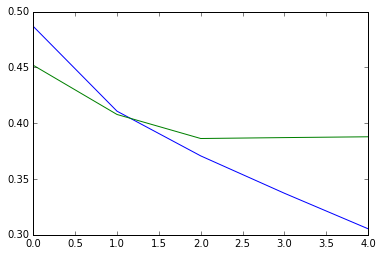

In [13]:
####################################################

print 'Summary Plots'

plt.plot(summary_stats.train_loss) # blue
plt.plot(summary_stats.valid_loss) # green
plt.show()

####################################################

In [14]:
####################################################

print 'Save the predictions to a file for submission'

model.load_weights( CNN_best_weights )

predictions = model.predict (
                             x       = [
                                        testing_data_1, 
                                        testing_data_2, 
                                        testing_data_1, 
                                        testing_data_2
                                       ], 
                             verbose = True
                            )

submission = pd.DataFrame(predictions, columns=['is_duplicate'])
submission.insert(0, 'test_id', testing_data_pd.test_id)
submission.to_csv('CNN_submission_to_kaggle.csv', index=False)

print 'Model Saved'

####################################################

Save the predictions to a file for submission
2345696/2345796 [============================>.] - ETA: 0sModel Saved


In [15]:
!pwd
!ls -l CNN_submission_to_kaggle.csv

/home/ubuntu/pynb
-rw-rw-r-- 1 ubuntu ubuntu 54242172 Aug 22 14:28 CNN_submission_to_kaggle.csv
